In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

In [ ]:
df = pd.read_csv('Fraud.csv')

# Since 6M data is too large, we take only 1M samples

In [ ]:
fraud = df[df['isFraud'] == 1]
nonfraud = df[df['isFraud'] == 0].sample(n=len(fraud)*100, random_state=42)
df = pd.concat([fraud, nonfraud]).sample(frac=1, random_state=42)

In [ ]:
df.size

9124643

In [ ]:
df[0:15]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
3992479,298,CASH_OUT,95370.10,C1497466008,105423.00,10052.90,C378281527,0.00,95370.10,0,0
456924,19,CASH_IN,240515.96,C1006306772,2531710.74,2772226.69,C470460030,15181403.40,14940887.45,0,0
5513274,380,CASH_OUT,29854.61,C864247831,0.00,0.00,C26206264,79315.43,109170.04,0,0
4467372,324,CASH_IN,312741.96,C2107908452,61840.82,374582.78,C1601533671,1480129.64,1167387.67,0,0
2507522,205,CASH_IN,242808.30,C1688571006,45976.00,288784.30,C985617765,574926.48,1684106.07,0,0
2968099,231,CASH_IN,203039.14,C1486506085,39733.00,242772.14,C299931599,536059.04,333019.90,0,0
99645,10,PAYMENT,6284.51,C2014512125,0.00,0.00,M681821432,0.00,0.00,0,0
1434293,140,CASH_OUT,93055.92,C948248053,32692.00,0.00,C889437609,1010848.30,1103904.22,0,0
4827633,347,CASH_IN,152026.30,C876479981,108.00,152134.30,C93382629,366969.13,214942.83,0,0
4164265,304,CASH_IN,70881.13,C408703637,688875.96,759757.09,C1511903187,7887330.81,7816449.68,0,0


In [ ]:
df.isna().sum()


,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
print("Total rows:", len(df))

Total rows: 829513


# Time step: each unit is 1 hour, spanning 30 days (744 steps total)

## Feature engineering ideas based on step:

| Derived Feature        | Code Example                                     | Use                                 |
| ---------------------- | ------------------------------------------------ | ----------------------------------- |
| **Hour of Day** (0–23) | `df['hour'] = df['step'] % 24`                   | Fraud may occur more often at night |
| **Day of Week** (0–6)  | `df['dayofweek'] = (df['step'] // 24) % 7`       | Weekly fraud trends                 |
| **Day Number** (1–31)  | `df['day'] = (df['step'] // 24) + 1`             | Look for end-of-month spikes        |
| **Weekend Indicator**  | `df['is_weekend'] = df['dayofweek'].isin([5,6])` | Fraud may increase during weekends  |


In [ ]:
# Time-based features from step
df['hour'] = df['step'] % 24
df['day'] = (df['step'] // 24) + 1
df['dayofweek'] = (df['step'] // 24) % 7
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)


In [ ]:
df.tail()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,hour,day,dayofweek,is_weekend
1878260,164,CASH_OUT,371667.05,C1265912212,0.0,0.00,C398823993,974669.23,1346336.29,0,0,20,7,6,1
5443170,378,CASH_OUT,351725.08,C326644539,1070.0,0.00,C1716365819,0.00,351725.08,0,0,18,16,1,0
3785347,280,PAYMENT,18265.45,C1150494225,40099.0,21833.55,M1121808623,0.00,0.00,0,0,16,12,4,0
2498690,204,CASH_OUT,231973.11,C1250182405,810.0,0.00,C1469800534,96860.25,328833.36,0,0,12,9,1,0
3458449,257,PAYMENT,631.94,C2015593879,0.0,0.00,M1224987502,0.00,0.00,0,0,17,11,3,0


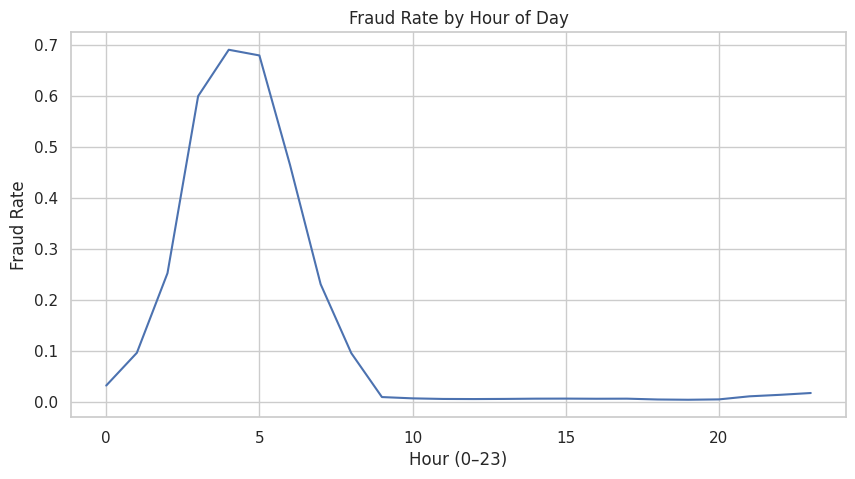

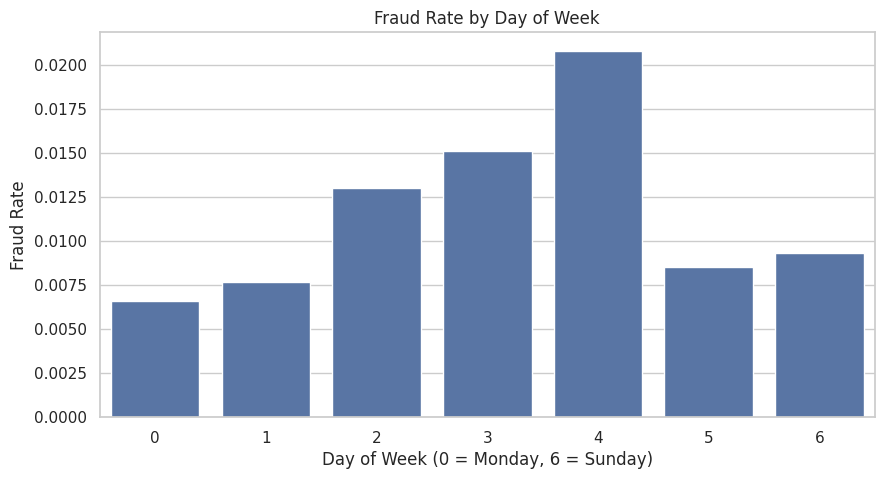

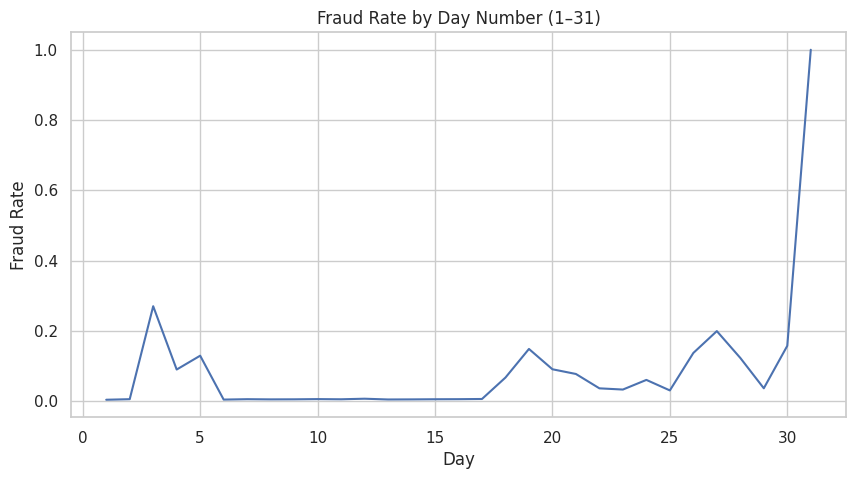

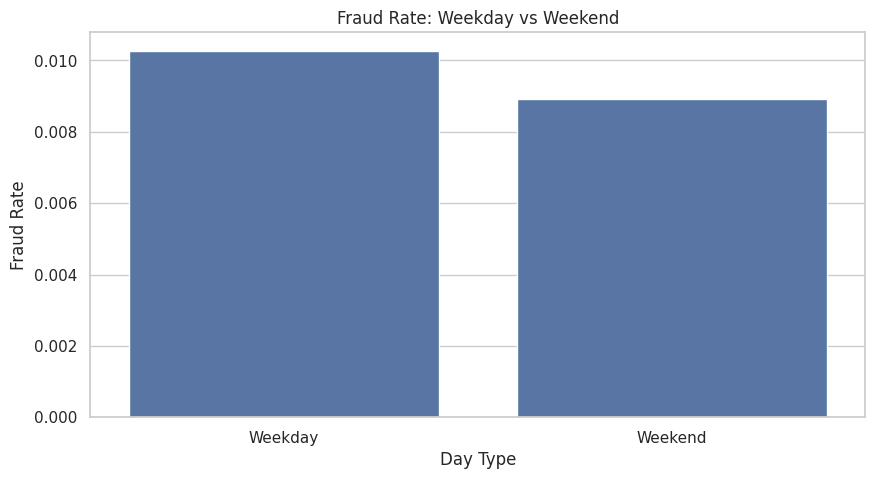

In [ ]:
# Plot 1: Fraud Rate by Hour of Day
plt.figure()
sns.lineplot(data=df, x='hour', y='isFraud', estimator='mean', errorbar=None)
plt.title("Fraud Rate by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Fraud Rate")
plt.show()

# Plot 2: Fraud Rate by Day of Week
plt.figure()
sns.barplot(data=df, x='dayofweek', y='isFraud', estimator='mean', errorbar=None)
plt.title("Fraud Rate by Day of Week")
plt.xlabel("Day of Week (0 = Monday, 6 = Sunday)")
plt.ylabel("Fraud Rate")
plt.show()

# Plot 3: Fraud Rate by Day Number
plt.figure()
sns.lineplot(data=df, x='day', y='isFraud', estimator='mean', errorbar=None)
plt.title("Fraud Rate by Day Number (1–31)")
plt.xlabel("Day")
plt.ylabel("Fraud Rate")
plt.show()

# Plot 4: Weekend vs Weekday Fraud Rate
plt.figure()
sns.barplot(data=df, x='is_weekend', y='isFraud', estimator='mean', errorbar=None)
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.title("Fraud Rate: Weekday vs Weekend")
plt.xlabel("Day Type")
plt.ylabel("Fraud Rate")
plt.show()

## Creating a binary feature is_end_of_month

Fraud is heavily skewed toward the last days.

Including this binary indicator helps models learn that end-of-month transactions are riskier.

In [ ]:
df['is_end_of_month'] = (df['day'] >= 30).astype(int)


## Encoing type of the transaction
Creating one column per transaction type (except one dropped to avoid redundancy).

In [ ]:
df = pd.get_dummies(df, columns=['type'], drop_first=True, dtype=int)

In [ ]:
df['type_DEBIT'].dtype

dtype('int64')

# Amount

NaNs: 0
Infs: 0


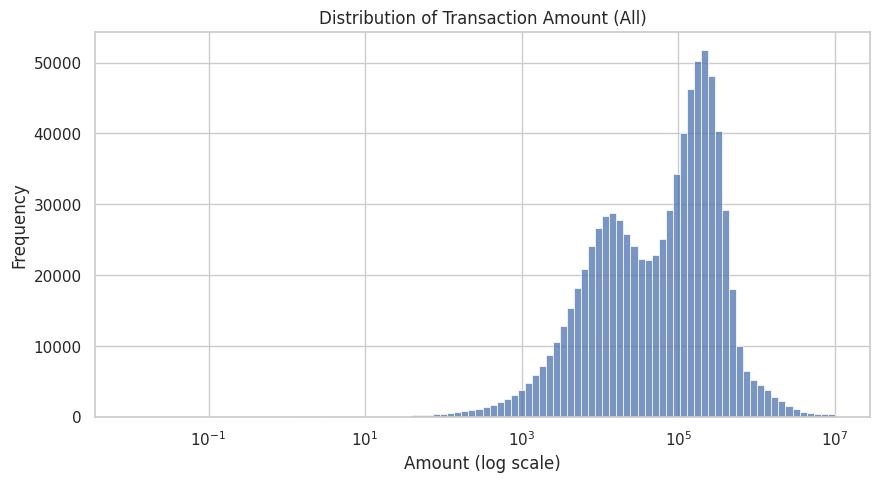

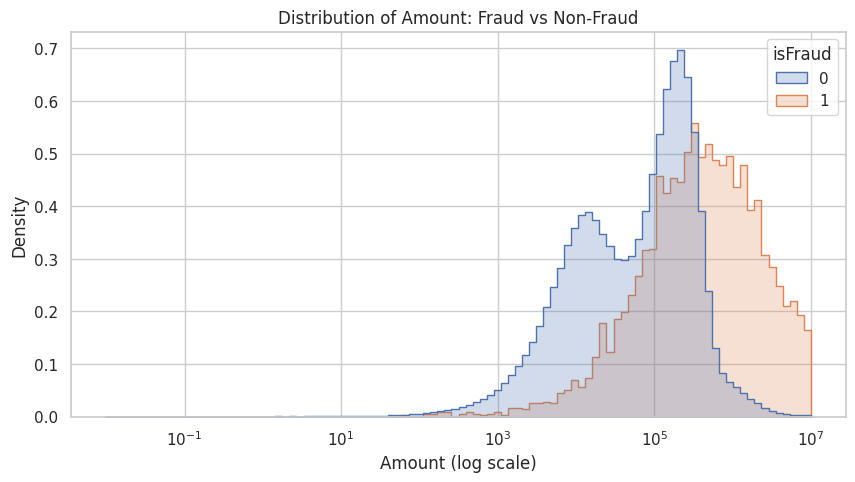

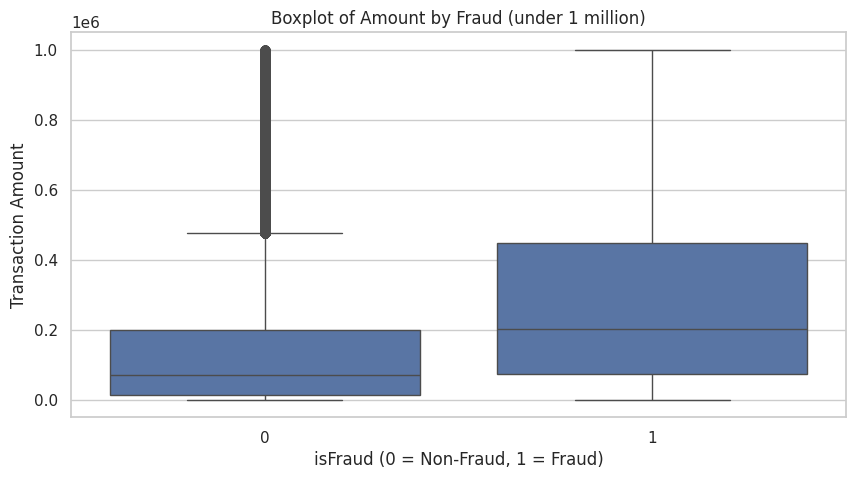

In [ ]:
# Confirm no NaNs or infs in amount
print("NaNs:", df['amount'].isna().sum())
print("Infs:", np.isinf(df['amount']).sum())

# Optional: filter extreme values for better plots
df_filtered = df[df['amount'] > 0]
df_filtered = df_filtered[df_filtered['amount'] < 1e7]  # filter out very large spikes if any

# Plot 1: Overall distribution (log scale, no KDE)
plt.figure()
sns.histplot(df_filtered['amount'], bins=100, log_scale=True)
plt.title("Distribution of Transaction Amount (All)")
plt.xlabel("Amount (log scale)")
plt.ylabel("Frequency")
plt.show()

# Plot 2: Fraud vs Non-Fraud comparison
plt.figure()
sns.histplot(data=df_filtered, x='amount', hue='isFraud', bins=100, log_scale=True,
             element='step', stat='density', common_norm=False)
plt.title("Distribution of Amount: Fraud vs Non-Fraud")
plt.xlabel("Amount (log scale)")
plt.ylabel("Density")
plt.show()

# Boxplot to show separation
plt.figure()
sns.boxplot(data=df_filtered[df_filtered['amount'] < 1e6], x='isFraud', y='amount')
plt.title("Boxplot of Amount by Fraud (under 1 million)")
plt.xlabel("isFraud (0 = Non-Fraud, 1 = Fraud)")
plt.ylabel("Transaction Amount")
plt.show()

## Creating a binary featur
Because:

₹200k is also the threshold for isFlaggedFraud.

And it’s where fraud frequency starts rising.

In [ ]:
df['is_high_amount'] = (df['amount'] > 200000).astype(int)


# Plot rate of high-value transactions by day

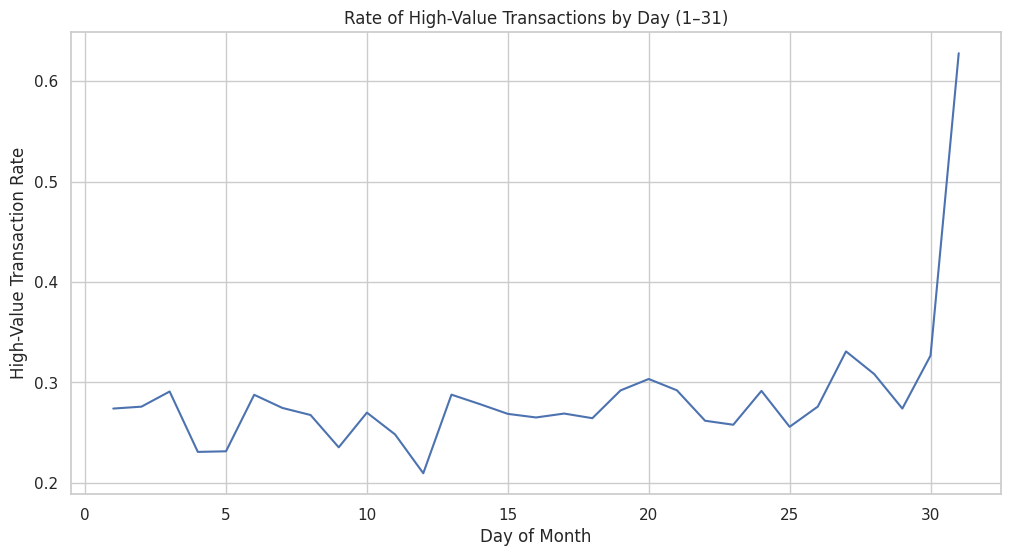

In [ ]:
high_value_rate = df.groupby('day')['is_high_amount'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=high_value_rate, x='day', y='is_high_amount')
plt.title("Rate of High-Value Transactions by Day (1–31)")
plt.xlabel("Day of Month")
plt.ylabel("High-Value Transaction Rate")
plt.grid(True)
plt.show()

# Droping nameOrig and nameDest

It’s:

A nominal, high-cardinality categorical variable (millions of unique values).

No inherent meaning in the IDs themselves — just anonymized tokens.

Impossible to generalize to unseen customer IDs in real-world deployment.

In [ ]:
# Drop customer and recipient name columns
df.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)


# Engineer Derived Features

| Feature                  | What It Detects                                                 |
| ------------------------ | --------------------------------------------------------------- |
| `errorOrig`, `errorDest` | Logical inconsistencies (missing money)                         |
| `is_full_drain`          | Sudden full withdrawals — common in fraud                       |
| `is_overdrawn`           | Impossible or flagged behavior                                  |
| `dest_unchanged`         | Transactions that didn't change receiver’s balance → often fake |

### 🔍 Rationale for Feature Selection

The features used in the model were carefully selected based on both domain intuition and observed patterns in the dataset. Here's why each group of features was included:

#### 1. **Time-based Features (`hour`, `day`, `dayofweek`, `is_weekend`, `is_end_of_month`)**
- These help identify **temporal fraud patterns**, such as spikes in fraud attempts during weekends or end-of-month periods.
- The `step` column was decomposed to better capture daily/weekly cycles in transaction behavior.

#### 2. **Transaction Type (`type_*`)**
- The type of transaction (e.g., TRANSFER, CASH_OUT) is **strongly correlated with fraud** in this dataset.
- Fraudulent behaviors often mimic real transfer/cash out operations, which makes encoding transaction type critical.

#### 3. **Amount-Based Feature (`is_high_amount`)**
- High-value transactions (above 200,000) are automatically flagged by the business model.
- Including this binary indicator helps the model leverage existing threshold-based logic.

#### 4. **Balance-Driven Features**
- `oldbalanceOrg`, `newbalanceOrig`, `oldbalanceDest`, `newbalanceDest` capture the movement of money between accounts.
- These are essential for detecting inconsistencies in how funds are handled.

#### 5. **Engineered Features**
- `errorOrig`: Difference between what the sender should have after the transaction vs. actual.
- `errorDest`: Imbalance in the recipient’s account after the transaction.
- `is_full_drain`: Indicates if the sender’s account was **fully emptied**, a common fraud signature.
- `is_overdrawn`: Shows if the transaction amount exceeded the sender’s balance.
- `dest_unchanged`: Highlights whether the recipient’s balance remained unchanged — this may point to suspicious/fake recipients.

Together, these features provide a **comprehensive behavioral and financial fingerprint** of each transaction, enabling the model to learn both normal and fraudulent patterns effectively.


In [ ]:
# 1. Sender balance error (should be close to 0 in legit transactions)
df['errorOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']

# 2. Receiver balance error
df['errorDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

# 3. Was sender fully drained?
df['is_full_drain'] = ((df['newbalanceOrig'] == 0) & (df['oldbalanceOrg'] > 0)).astype(int)

# 4. Was sender balance already zero?
df['is_zero_balance'] = (df['oldbalanceOrg'] == 0).astype(int)

# 5. Is transaction amount > balance? (overdrawn or suspicious)
df['is_overdrawn'] = (df['amount'] > df['oldbalanceOrg']).astype(int)

# 6. Was the destination untouched? (can indicate fake/faulty receiver)
df['dest_unchanged'] = (df['oldbalanceDest'] == df['newbalanceDest']).astype(int)


# Droping isFlaggedFraud
It’s redundant — it encodes a simple business rule:
TRANSFER and amount > 200,000

It adds no new signal that our ML model can’t already infer from:

type

amount

It might even cause data leakage if your model learns to rely on it instead of learning more robust patterns.

In [ ]:
# Drop it cleanly
df.drop('isFlaggedFraud', axis=1, inplace=True)


In [ ]:
df.tail()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,hour,day,dayofweek,...,type_DEBIT,type_PAYMENT,type_TRANSFER,is_high_amount,errorOrig,errorDest,is_full_drain,is_zero_balance,is_overdrawn,dest_unchanged
1878260,164,371667.05,0.0,0.00,974669.23,1346336.29,0,20,7,6,...,0,0,0,1,-371667.05,0.01,0,1,1,0
5443170,378,351725.08,1070.0,0.00,0.00,351725.08,0,18,16,1,...,0,0,0,1,-350655.08,0.00,1,0,1,0
3785347,280,18265.45,40099.0,21833.55,0.00,0.00,0,16,12,4,...,0,1,0,0,0.00,-18265.45,0,0,0,1
2498690,204,231973.11,810.0,0.00,96860.25,328833.36,0,12,9,1,...,0,0,0,1,-231163.11,0.00,1,0,1,0
3458449,257,631.94,0.0,0.00,0.00,0.00,0,17,11,3,...,0,1,0,0,-631.94,-631.94,0,1,1,1


In [ ]:
df.columns

Index(['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest',
       'newbalanceDest', 'isFraud', 'hour', 'day', 'dayofweek', 'is_weekend',
       'is_end_of_month', 'type_CASH_OUT', 'type_DEBIT', 'type_PAYMENT',
       'type_TRANSFER', 'is_high_amount', 'errorOrig', 'errorDest',
       'is_full_drain', 'is_zero_balance', 'is_overdrawn', 'dest_unchanged'],
      dtype='object')

# Class imbalance (fraud is rare)

The output shows that 96% is non-fraud (0) and 4% fraud (1) out of the data.

If we don’t address this imbalance:

The model might just learn to predict 0 (non-fraud) for everything.

We'll get high accuracy but terrible recall for frauds.


In [ ]:
df['isFraud'].value_counts(normalize=True)

,proportion
isFraud,
0,0.990099
1,0.009901


# Spliting the dataset and using SMOTE

In [ ]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

# 2. Train-test split (do this BEFORE applying SMOTE!)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3. Apply SMOTE only on training set
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)

# XGBoost Model

In [ ]:
# ✅ 2. Initialize the model
xgb = XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'
)

# ✅ 3. Train the model
xgb.fit(X_train_res, y_train_res)

# ✅ 4. Make predictions on original test set
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]  # For ROC AUC

# ✅ 5. Evaluation
print("📊 Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [15:33:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


📊 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    164260
           1       0.99      0.99      0.99      1643

    accuracy                           1.00    165903
   macro avg       0.99      1.00      1.00    165903
weighted avg       1.00      1.00      1.00    165903



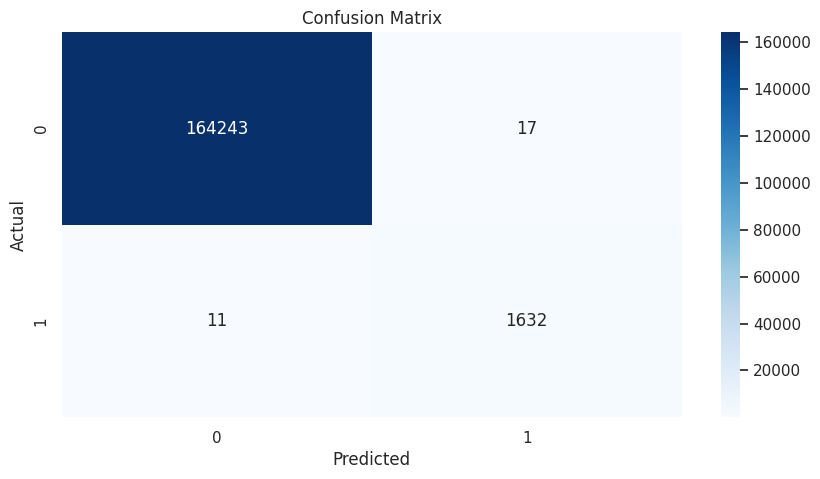

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
roc_score = roc_auc_score(y_test, y_proba)
print(f"🔍 ROC AUC Score: {roc_score:.4f}")

🔍 ROC AUC Score: 0.9995


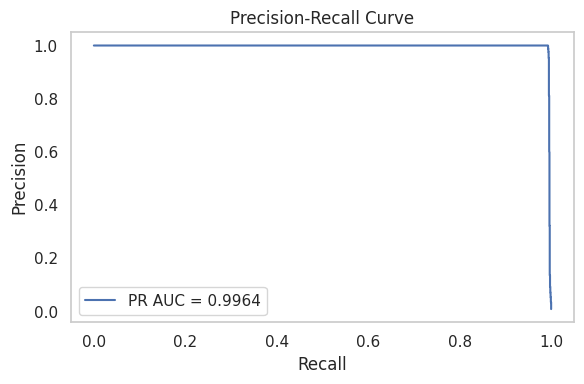

In [ ]:
# ✅ 7. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, label=f"PR AUC = {pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### 🔍 Interpretation of Feature Importance (XGBoost)

The bar plot below shows the features that contribute most to predicting fraudulent transactions in our dataset.

#### 📌 Top Predictive Features:

1. **errorOrig** — 🔥 *Most important feature*. This represents the inconsistency between sender’s balance before and after the transaction. Fraudulent activity often introduces irregularities here (e.g., mismatched balance subtraction).
2. **newbalanceOrig** — Reflects the account balance post-transaction. Fraudsters often drain accounts completely, leading to distinctive values.
3. **is_full_drain** — A binary flag that shows whether the sender’s balance was completely drained. This is a strong fraud indicator.
4. **is_overdrawn** — Indicates whether the transaction amount exceeds the sender’s balance. Though rare in legit operations, it's common in attempted frauds.
5. **errorDest** — Captures inconsistency in the recipient’s balance. Helps detect whether the receiver actually got the money, which may not happen in fraudulent transfers.
6. **amount** — While not as dominant, the transaction amount still plays a role. High-value or oddly small transactions might be suspicious.
7. **Transaction Type (e.g., type_PAYMENT)** — The method of transfer can also signal potential fraud, especially if certain types are abused.

#### 🧩 Less Contributive Features:
Variables like `is_end_of_month`, `is_weekend`, and even `step` (hour of simulation) have very low influence — but were retained for completeness and potential interaction effects.

---

#### 🧠 Do These Factors Make Sense?
Yes. Fraud patterns typically involve:
- Draining accounts (zero balances)
- Balance inconsistencies (engineered error fields)
- Specific transaction types (e.g., TRANSFER/CASH_OUT)
- Sudden large transactions

These patterns are reflected in your model’s top features, supporting the validity of the model’s logic.

/tmp/ipython-input-95-766506852.py:10: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


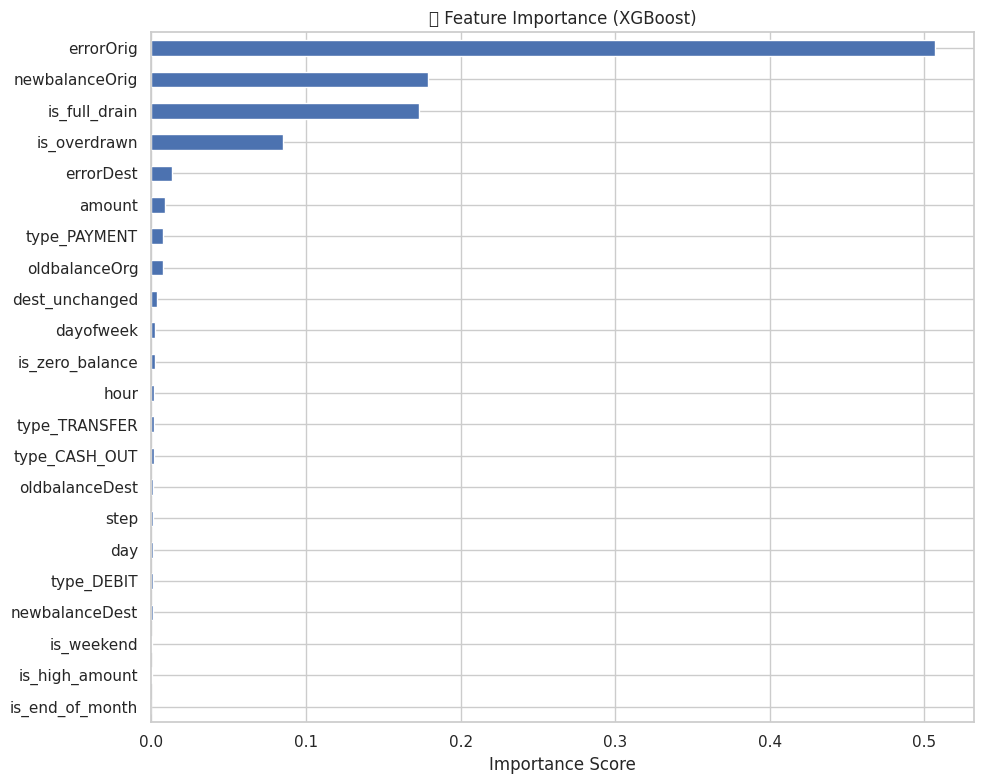

In [ ]:
# Get feature importances from the trained XGBoost model
importances = xgb.feature_importances_
features = pd.Series(importances, index=X_train.columns).sort_values(ascending=True)

# Plot horizontal bar chart
plt.figure(figsize=(10, 8))
features.plot(kind='barh')
plt.title('🔍 Feature Importance (XGBoost)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

# Custom Check

In [ ]:
def predict_fraud_transaction(input_data, model):
    import pandas as pd

    # Step 1: Create DataFrame
    custom_df = pd.DataFrame([input_data])

    # Step 2: Time-based features
    custom_df['hour'] = custom_df['step'] % 24
    custom_df['day'] = (custom_df['step'] // 24) + 1
    custom_df['dayofweek'] = custom_df['day'] % 7
    custom_df['is_weekend'] = custom_df['dayofweek'].isin([5, 6]).astype(int)
    custom_df['is_end_of_month'] = (custom_df['day'] >= 30).astype(int)

    # Step 3: One-hot encode `type` with fixed set
    for t in ['CASH_OUT', 'DEBIT', 'PAYMENT', 'TRANSFER']:
        custom_df[f'type_{t}'] = (custom_df['type'] == t).astype(int)
    custom_df.drop('type', axis=1, inplace=True)

    # Step 4: High amount flag
    custom_df['is_high_amount'] = (custom_df['amount'] > 200000).astype(int)

    # Step 5: Engineered features
    custom_df['errorOrig'] = custom_df['oldbalanceOrg'] - custom_df['newbalanceOrig'] - custom_df['amount']
    custom_df['errorDest'] = custom_df['newbalanceDest'] - custom_df['oldbalanceDest'] - custom_df['amount']
    custom_df['is_full_drain'] = ((custom_df['newbalanceOrig'] == 0) & (custom_df['oldbalanceOrg'] > 0)).astype(int)
    custom_df['is_zero_balance'] = (custom_df['oldbalanceOrg'] == 0).astype(int)
    custom_df['is_overdrawn'] = (custom_df['amount'] > custom_df['oldbalanceOrg']).astype(int)
    custom_df['dest_unchanged'] = (custom_df['oldbalanceDest'] == custom_df['newbalanceDest']).astype(int)

    # Step 6: Ensure column order matches training
    X_input = custom_df[model.feature_names_in_]  # If your model has this attribute

    # Step 7: Predict
    pred = model.predict(X_input)[0]
    proba = model.predict_proba(X_input)[0][1]

    return {
        'prediction': 'FRAUD' if pred == 1 else 'NOT FRAUD',
        'probability': round(proba, 4)
    }


In [ ]:
input_data = {
    'step': 1,
    'type': 'DEBIT',
    'amount': 5337.77,
    'oldbalanceOrg': 41720.0,
    'newbalanceOrig': 36382.23,
    'oldbalanceDest': 41898.0,
    'newbalanceDest': 40348.79
}

result = predict_fraud_transaction(input_data, xgb)
print(f"Prediction: {result['prediction']} (probability: {result['probability']})")

Prediction: NOT FRAUD (probability: 0.00019999999494757503)


# Infrastructure Prevention Plan
Based on the analysis and the most predictive features identified, here are several infrastructure-level strategies a company can adopt to help prevent fraudulent transactions:

✅ Flag transactions with high errorOrig values:
If the sender’s initial balance does not align with the amount deducted and the final balance (errorOrig), it may indicate manipulation or fraud.

✅ Limit transfer volumes near the end of the month:
Analysis showed an increased frequency of high-value or fraudulent transactions toward the end of each month. Implement stricter rules or extra validation for such periods.

✅ Trigger alerts on full account drains (is_full_drain):
Fraudsters often attempt to empty entire balances. Automatic alerts should be generated when a user's post-transaction balance becomes zero.

✅ Monitor and block transactions from accounts with zero starting balance (is_zero_balance):
Initiating large transactions from a zero-balance account is a common red flag.

✅ Flag transactions where the destination account (dest_unchanged) does not reflect the transferred amount:
If the destination balance doesn’t change after a large transfer, it may indicate a fake or compromised receiving account.

These strategies can be encoded as real-time rules in the transaction monitoring infrastructure and supported by the ML model to enhance detection.